# Image Inpainting Through Multi-Scale Partial Convolutions

Partial Convolution layers play a vital role in deep learning-based inpainting methods. However, existing approaches often employ them directly, resulting in certain limitations like indistinct textures and a deficiency of overall structural information in the inpainting outcomes. In order to tackle these challenges, we present a solution called the Multi-Scale Feature Extraction and Fusion (MSFEF) module. This module consists of parallel convolution layers with varying kernel sizes, which are weighted and combined to incorporate both local and global information surrounding the missing pixels. We integrate the MSFEF module into the encoder of a simple encoder-decoder architecture. By conducting experiments on Helen, Stanford Cars, and a subset of LSUN datasets, we demonstrate the superiority of our approach in terms of both quantitative and qualitative evaluations. Notably, our method achieves impressive inpainting results even with a straightforward encoder-decoder architecture, highlighting the effectiveness of the MSFEF module. Some examples can be found below: 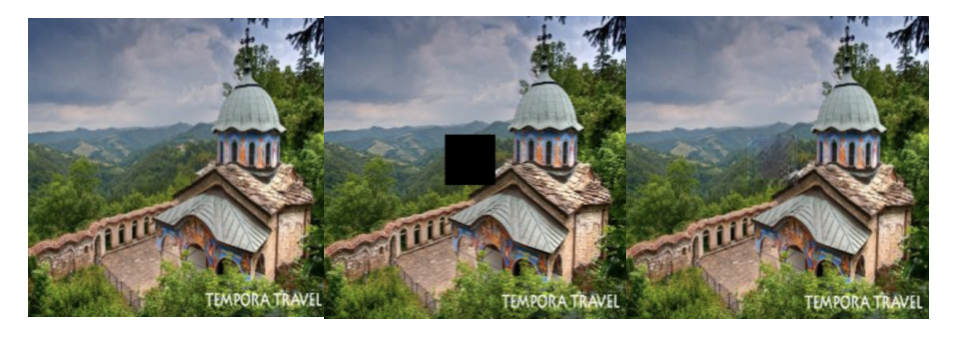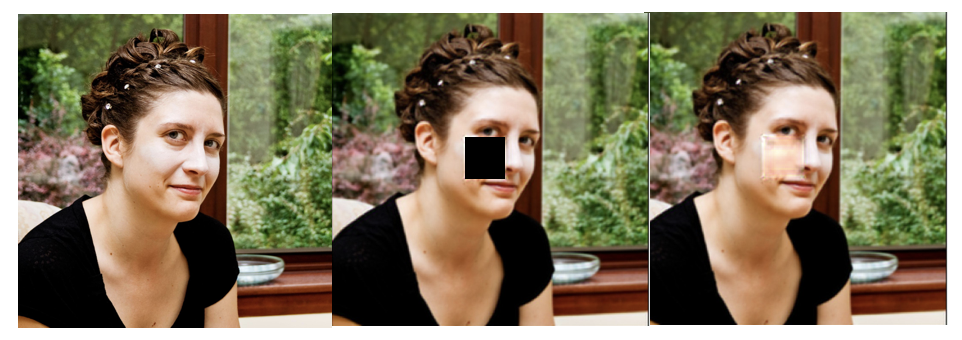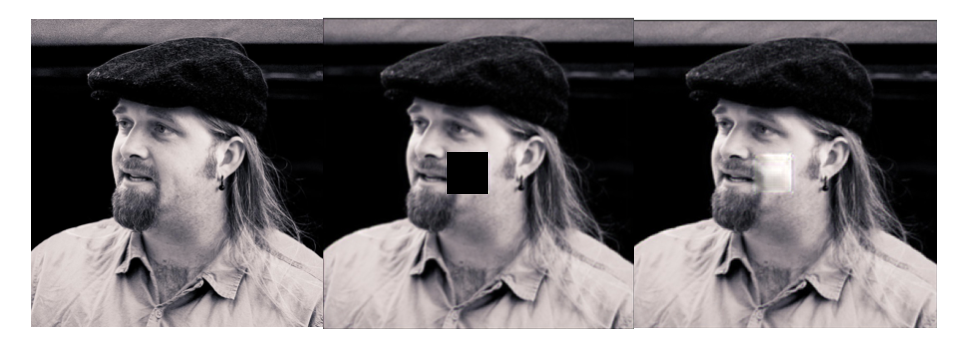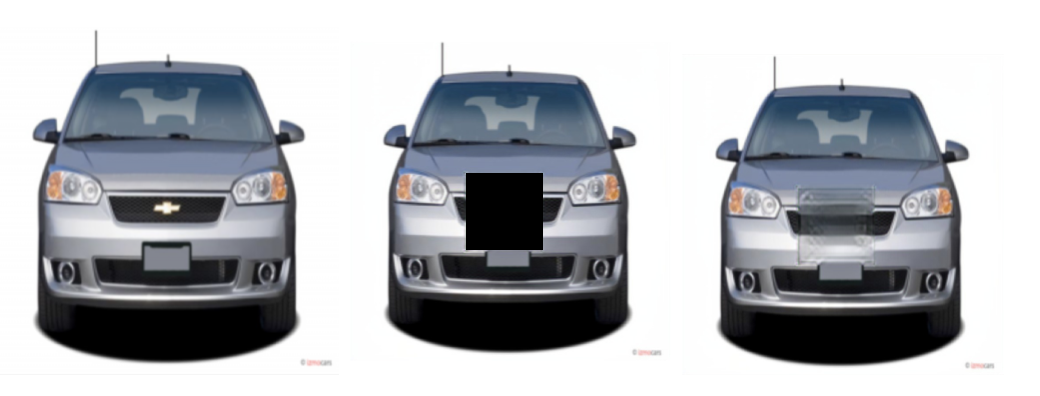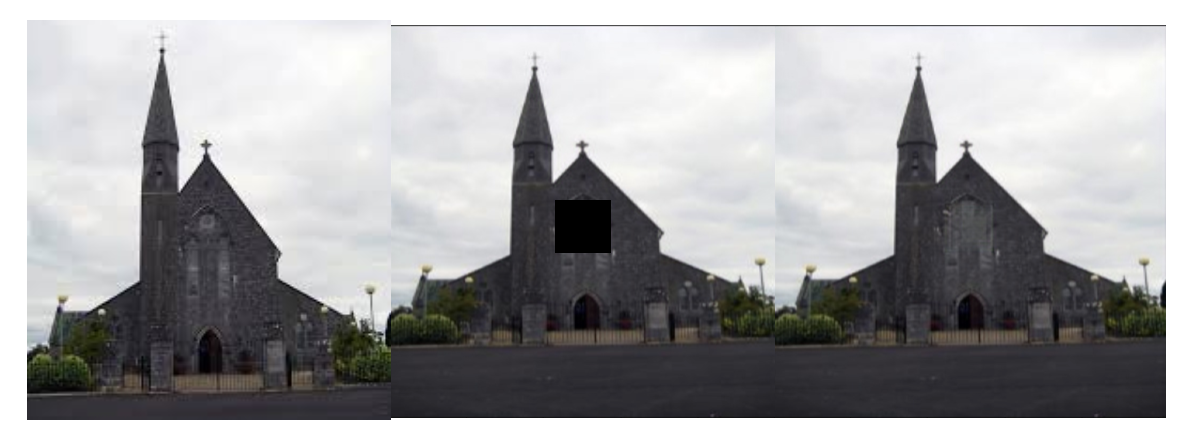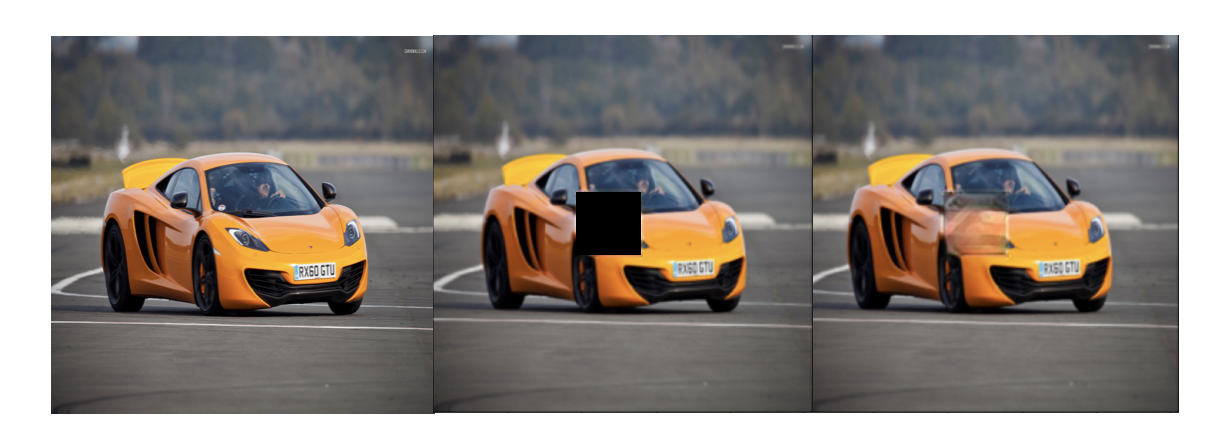


## Installing and Importing Necessary Libraries

In [ ]:
!pip install torchmetrics
!pip install pytorch-ignite
!pip install torch-fidelity
!pip install lpips

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset
import os
import os.path as osp
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import random
import math
import torch.nn.functional as F
import cv2
from torch.autograd import Variable
from torchvision import models
import torchmetrics
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import lpips
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

We first define the class for Partial convolution.

In [ ]:
class PartialConv2d(nn.Module):

    """
    PartialConv2d performs the partial convolution operation.
    More information on partial convolution can be found here: https://arxiv.org/abs/1804.07723

    Args:
        - in_channels : int : Number of input channels.
        - out_channels : int : Number of output channels.
        - kernel_size : int : Size of the convolutional kernel (default: 3).
        - stride : int : Stride value for the convolution operation (default: 1).
        - padding : int : Padding value for the convolution operation (default: 0).
        - return_mask : bool : Whether to return the update mask along with the output (default: False).

    Attributes:
        - return_mask : bool : Whether to return the update mask along with the output.
        - in_channels : int : Number of input channels.
        - out_channels : int : Number of output channels.
        - kernel_size : tuple : Size of the convolutional kernel.
        - padding : int : Padding value for the convolution operation.
        - stride : int : Stride value for the convolution operation.
        - slide_winsize : int : Size of the sliding window for calculating the mask ratio.
        - update_mask : torch.Tensor : The update mask computed during the forward pass.
        - mask_ratio : torch.Tensor : The mask ratio computed during the forward pass.
        - input_conv : nn.Conv2d : Convolutional layer for the input.
        - mask_conv : nn.Conv2d : Convolutional layer for the mask.

    """

    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 0, return_mask = False):

        super().__init__()

        # check whether the mask is multi-channel or not
        if return_mask:
            self.return_mask = True
        else:
            self.return_mask = False

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.kernel_size = (kernel_size, kernel_size)
        self.padding = padding
        self.stride = stride

        self.slide_winsize = self.in_channels * self.kernel_size[0] * self.kernel_size[1]

        self.update_mask = None
        self.mask_ratio = None

        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride, padding, bias = True)
        nn.init.kaiming_normal_(self.input_conv.weight)

        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride, padding, bias = False)

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False


    def forward(self, input, mask_in=None):
      """
        Performs the forward pass of the PartialConv2d module.

        Args:
            - input : torch.Tensor : Input tensor of shape (batch_size, in_channels, height, width).
            - mask_in : torch.Tensor : Mask tensor of shape (batch_size, 1, height, width) (default: None).

        Returns:
            - output : torch.Tensor : Output tensor of shape (batch_size, out_channels, height, width).
            - update_mask : torch.Tensor : Update mask tensor of shape (batch_size, out_channels, height, width) (returned only if `return_mask` is True).

        """

        assert len(input.shape) == 4

        with torch.no_grad():

            mask = mask_in

            self.update_mask = self.mask_conv(mask)

            self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
            self.update_mask = torch.clamp(self.update_mask, 0, 1)
            self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = self.input_conv(torch.mul(input,mask))

        output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(raw_out)
        output = torch.mul(raw_out - output_bias, self.mask_ratio) + output_bias

        if self.return_mask:
            return output, self.update_mask
        else:
            return output

We now define the class for MSFEF (Multi-Scale Feature Extraction Fusion) module. The architecture is shown below:
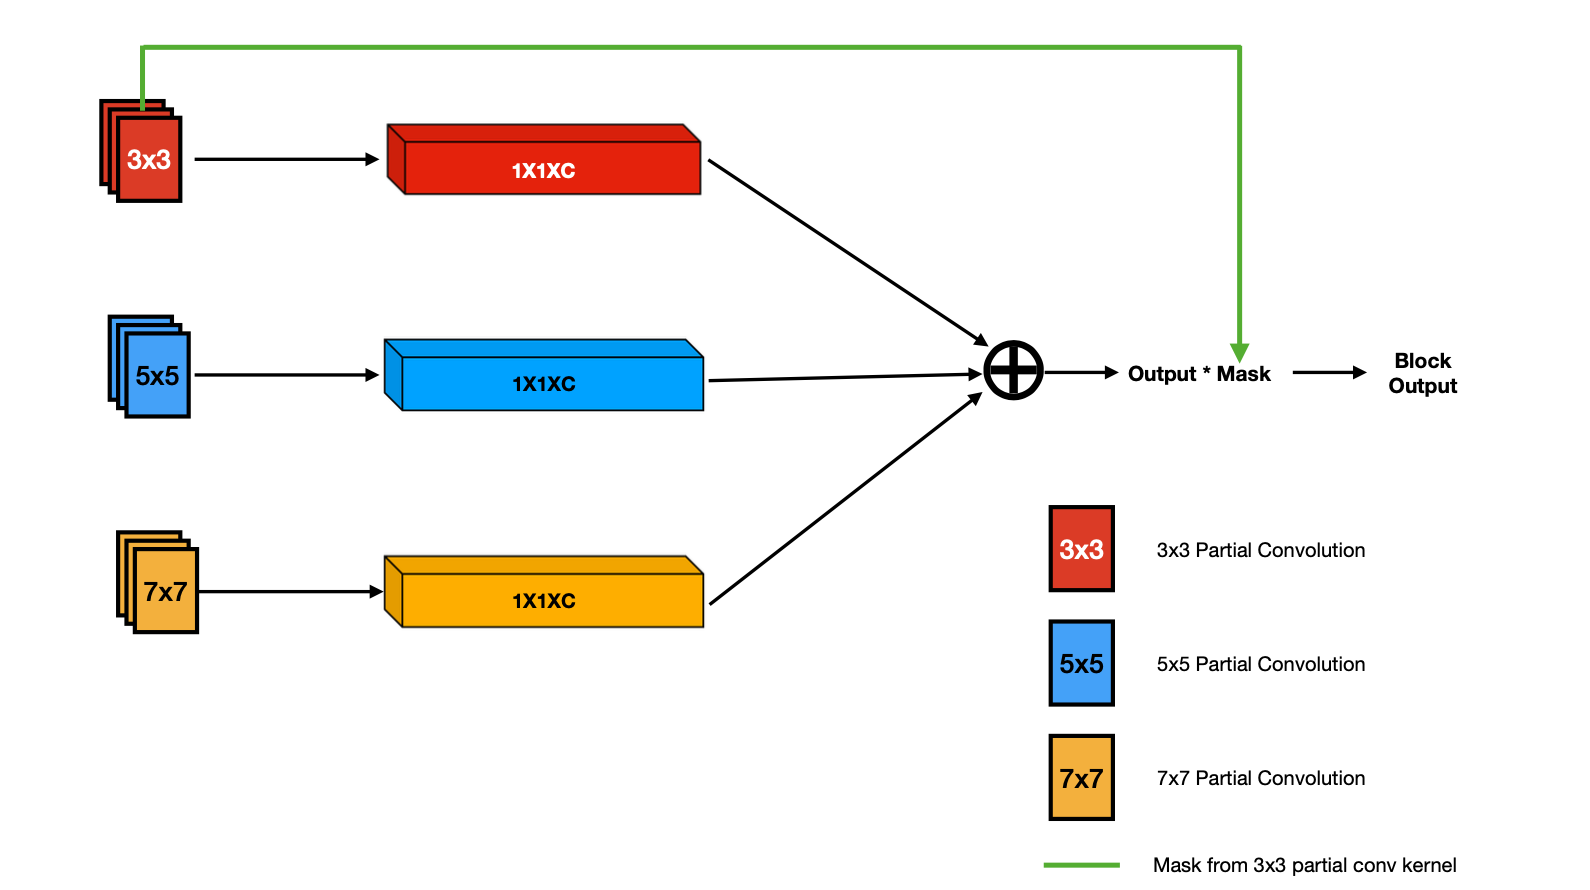


In [ ]:
class MSFEF(nn.Module):

    """
    MSFEF (Multi-Scale Feature Extraction Fusion) module for partial convolution.

    Args:
        - in_channels : int : Number of input channels.
        - out_channels : int : Number of output channels.
        - kernel_sizes : tuple : Sizes of the convolutional kernels (default: (3, 5, 7)).
        - downsample : bool : Whether to downsample the input (default: True).

    Shape:
        - Input: (batch_size, in_channels, height, width)
        - Mask: (batch_size, 1, height, width)
        - Output: (batch_size, out_channels, height, width)
        - Mask Out: (batch_size, out_channels, height, width)

    Attributes:
        - pconv1 : PartialConv2d module with the first kernel size.
        - pconv2 : PartialConv2d module with the second kernel size.
        - pconv3 : PartialConv2d module with the third kernel size.
        - weight_tensor_1 : nn.Parameter : Weight tensor for the first convolution output.
        - weight_tensor_2 : nn.Parameter : Weight tensor for the second convolution output.
        - weight_tensor_3 : nn.Parameter : Weight tensor for the third convolution output.

    """

  def __init__(self, in_channels, out_channels, kernel_sizes = (3, 5, 7), downsample = True):

    super().__init__()

    if downsample:
      stride = 2
    else:
      stride = 1

    self.pconv1 = PartialConv2d(in_channels, out_channels, kernel_size = kernel_sizes[0], stride = stride,
                                padding = math.ceil((kernel_sizes[0] - 2)/2), return_mask= True)

    self.pconv2 = PartialConv2d(in_channels, out_channels, kernel_size = kernel_sizes[1], stride = stride,
                                padding = math.ceil((kernel_sizes[1] - 2)/2), return_mask= False)

    self.pconv3 = PartialConv2d(in_channels, out_channels, kernel_size = kernel_sizes[2], stride = stride,
                                padding = math.ceil((kernel_sizes[2] - 2)/2), return_mask= False)

    self.weight_tensor_1 = nn.Parameter(torch.Tensor(out_channels, 1, 1))

    self.weight_tensor_2 = nn.Parameter(torch.Tensor(out_channels, 1, 1))

    self.weight_tensor_3 = nn.Parameter(torch.Tensor(out_channels, 1, 1))

    nn.init.xavier_uniform_(self.weight_tensor_1)
    nn.init.xavier_uniform_(self.weight_tensor_2)
    nn.init.xavier_uniform_(self.weight_tensor_3)

  def forward(self, x, mask):
    """
    Performs the forward pass of the MSFEF module.

    Args:
      - x : torch.Tensor : Input tensor of shape (batch_size, in_channels, height, width).
      - mask : torch.Tensor : Mask tensor of shape (batch_size, 1, height, width).

    Returns:
      - final_out : torch.Tensor : Final output tensor of shape (batch_size, out_channels, height, width).
      - mask_out : torch.Tensor : Update mask tensor of shape (batch_size, out_channels, height, width).

    """

    conv1out, mask_out = self.pconv1(x, mask)
    conv2out = self.pconv2(x, mask)
    conv3out = self.pconv3(x, mask)

    weighted_out = torch.multiply(conv1out, self.weight_tensor_1) + torch.multiply(conv2out, self.weight_tensor_2) + torch.multiply(conv3out, self.weight_tensor_3)

    final_out = torch.multiply(weighted_out, mask_out)

    return final_out, mask_out

In [ ]:
# Sanity Check
a = torch.zeros(1,3,32,32)
mask = torch.zeros(1,3,32,32)

sample_layer = MSFEF(in_channels = 3, out_channels = 64, downsample = False)

with torch.no_grad():
    b, b_mask = sample_layer(a, mask)

print(b.size())

In [ ]:
class EncoderDecoder(nn.Module):

      def __init__(self):
        """Encoder-Decoder model for image processing."""

            super().__init__()

            self.out_cache = []
            self.mask_cache = []

            self.econv1 = MSFEF(in_channels = 3, out_channels = 64, downsample = True)
            self.bnorm1  = nn.InstanceNorm2d(64, affine=True)

            self.econv2  = MSFEF(in_channels = 64, out_channels = 128, downsample = True)
            self.bnorm2  = nn.InstanceNorm2d(128, affine=True)

            self.econv3  = MSFEF(in_channels = 128, out_channels = 256, downsample = True)
            self.bnorm3  = nn.InstanceNorm2d(256, affine=True)

            self.econv4  =  MSFEF(in_channels = 256, out_channels = 512, downsample = True)
            self.bnorm4  =  nn.InstanceNorm2d(512, affine=True)

            self.econv5  = PartialConv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2,
                        padding = 1, return_mask= True)
            self.bnorm5  = nn.InstanceNorm2d(512, affine=True)

            self.econv6  = PartialConv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2,
                        padding = 1, return_mask= True)
            self.bnorm6  = nn.InstanceNorm2d(512, affine=True)

            self.econv7  = PartialConv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2,
                        padding = 1, return_mask= True)
            self.bnorm7  = nn.InstanceNorm2d(512, affine=True)

            self.econv8  = PartialConv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2,
                        padding = 1, return_mask= True)
            self.bnorm8  = nn.BatchNorm2d(512)

            self.dconv1 = PartialConv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm11 = nn.BatchNorm2d(512)

            self.dconv2 = PartialConv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm12 = nn.BatchNorm2d(512)

            self.dconv3 =  PartialConv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm13 = nn.BatchNorm2d(512)


            self.dconv4 =  PartialConv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm14 = nn.BatchNorm2d(512)

            self.dconv5 =  PartialConv2d(in_channels = 768, out_channels = 256, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm15 = nn.BatchNorm2d(256)

            self.dconv6 =  PartialConv2d(in_channels = 384, out_channels = 128, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm16 = nn.BatchNorm2d(128)

            self.dconv7 =  PartialConv2d(in_channels = 192, out_channels = 64, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm17 = nn.BatchNorm2d(64)

            self.dconv8 =  PartialConv2d(in_channels = 67, out_channels = 3, kernel_size = 3, stride = 1,
                        padding = 1, return_mask= True)
            self.bnorm18 = nn.BatchNorm2d(3)

            self.up = nn.UpsamplingNearest2d(scale_factor = 2)

            self.leaky_relu  = nn.LeakyReLU(0.2, inplace = True)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

      def forward(self, x, mask):
        """Perform forward pass through the encoder-decoder model.

        Args:
            - x : torch.Tensor : Input image tensor.
            - mask : torch.Tensor : Mask tensor.

        Returns:
            - dout_8 : torch.Tensor : Output image tensor.
            - dmask_8 : torch.Tensor : Output mask tensor.
        """

            x = x * mask
            out_1, mask_1 = self.econv1(x, mask)
            out_1 = self.relu(self.bnorm1(out_1))

            out_2, mask_2 = self.econv2(out_1, mask_1)
            out_2 = self.relu(self.bnorm2(out_2))

            out_3, mask_3 = self.econv3(out_2, mask_2)
            out_3 = self.relu(self.bnorm3(out_3))

            out_4, mask_4 = self.econv4(out_3, mask_3)
            out_4 = self.relu(self.bnorm4(out_4))

            out_5, mask_5 = self.econv5(out_4, mask_4)
            out_5 = self.relu(self.bnorm5(out_5))

            out_6, mask_6 = self.econv6(out_5, mask_5)
            out_6 = self.relu(self.bnorm6(out_6))

            out_7, mask_7 = self.econv7(out_6, mask_6)
            out_7 = self.relu(self.bnorm7(out_7))

            out_8, mask_8 = self.econv8(out_7, mask_7)
            out_8 = self.relu(self.bnorm8(out_8))

            #Decoder

            dout_1 = self.up(out_8)
            dmask_1 = self.up(mask_8)
            dout_1 = torch.cat([dout_1, out_7], dim=1)
            dmask_1 = torch.cat([dmask_1, mask_7], dim=1)
            dout_1, dmask_1 = self.dconv1(dout_1, dmask_1)
            dout_1 = self.leaky_relu(self.bnorm11(dout_1))

            dout_2 = self.up(dout_1)
            dmask_2 = self.up(dmask_1)
            dout_2 = torch.cat([dout_2, out_6], dim=1)
            dmask_2 = torch.cat([dmask_2, mask_6], dim=1)
            dout_2, dmask_2 = self.dconv2(dout_2, dmask_2)
            dout_2 = self.leaky_relu(self.bnorm12(dout_2))

            dout_3 = self.up(dout_2)
            dmask_3 = self.up(dmask_2)
            dout_3 = torch.cat([dout_3, out_5], dim=1)
            dmask_3 = torch.cat([dmask_3, mask_5], dim=1)
            dout_3, dmask_3 = self.dconv3(dout_3, dmask_3)
            dout_3 = self.leaky_relu(self.bnorm13(dout_3))

            dout_4 = self.up(dout_3)
            dmask_4 = self.up(dmask_3)
            dout_4 = torch.cat([dout_4, out_4], dim=1)
            dmask_4 = torch.cat([dmask_4, mask_4], dim=1)
            dout_4, dmask_4 = self.dconv4(dout_4, dmask_4)
            dout_4 = self.leaky_relu(self.bnorm14(dout_4))

            dout_5 = self.up(dout_4)
            dmask_5 = self.up(dmask_4)
            dout_5 = torch.cat([dout_5, out_3], dim=1)
            dmask_5 = torch.cat([dmask_5, mask_3], dim=1)
            dout_5, dmask_5 = self.dconv5(dout_5, dmask_5)
            dout_5 = self.leaky_relu(self.bnorm15(dout_5))

            dout_6 = self.up(dout_5)
            dmask_6 = self.up(dmask_5)
            dout_6 = torch.cat([dout_6, out_2], dim=1)
            dmask_6 = torch.cat([dmask_6, mask_2], dim=1)
            dout_6, dmask_6 = self.dconv6(dout_6, dmask_6)
            dout_6 = self.leaky_relu(self.bnorm16(dout_6))

            dout_7 = self.up(dout_6)
            dmask_7 = self.up(dmask_6)
            dout_7 = torch.cat([dout_7, out_1], dim=1)
            dmask_7 = torch.cat([dmask_7, mask_1], dim=1)
            dout_7, dmask_7 = self.dconv7(dout_7, dmask_7)
            dout_7 = self.leaky_relu(self.bnorm17(dout_7))

            dout_8 = self.up(dout_7)
            dmask_8 = self.up(dmask_7)
            dout_8 = torch.cat([dout_8, x], dim=1)
            dmask_8 = torch.cat([dmask_8, mask], dim=1)
            dout_8, dmask_8 = self.dconv8(dout_8, dmask_8)

            return dout_8, dmask_8

In [ ]:
# Sanity Check
a = torch.zeros(2,3,256,256)
mask = torch.zeros(2,3,256,256)

sample_model = EncoderDecoder()

with torch.no_grad():
    b, b_mask = sample_model(a, mask)

print(b.size())

In [ ]:
#Loss functions
def l1_pixel_loss(img1, img2):

    """Calculate the L1 pixel loss between two images.

    Args:
        - img1 : torch.Tensor : First input image tensor.
        - img2 : torch.Tensor : Second input image tensor.

    Returns:
        - loss: torch.Tensor : L1 pixel loss.
    """

    loss = torch.mean(torch.square(img1 - img2))

    return loss

In [ ]:
"""VGG Losses"""

def gram_matrix(input_tensor):
    """
    Compute Gram matrix

    :param input_tensor: input tensor with shape
     (batch_size, nbr_channels, height, width)
    :return: Gram matrix of y
    """
    (b, ch, h, w) = input_tensor.size()
    features = input_tensor.view(b, ch, w * h)
    features_t = features.transpose(1, 2)

    input = torch.zeros(b, ch, ch).type(features.type())
    gram = torch.baddbmm(input, features, features_t, beta=0, alpha=1./(ch * h * w), out=None)

    return gram

class PerceptualLoss(nn.Module):
    """
    Perceptual Loss Module
    """
    def __init__(self):
        """Init"""
        super().__init__()
        self.l1_loss = torch.nn.L1Loss()
        self.mse_loss = torch.nn.MSELoss()

    @staticmethod
    def normalize_batch(batch, div_factor=255.):
        """
        Normalize batch

        :param batch: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param div_factor: normalizing factor before data whitening
        :return: normalized data, tensor with shape
         (batch_size, nbr_channels, height, width)
        """
        # normalize using imagenet mean and std
        mean = batch.data.new(batch.data.size())
        std = batch.data.new(batch.data.size())
        mean[:, 0, :, :] = 0.485
        mean[:, 1, :, :] = 0.456
        mean[:, 2, :, :] = 0.406
        std[:, 0, :, :] = 0.229
        std[:, 1, :, :] = 0.224
        std[:, 2, :, :] = 0.225
        batch = torch.div(batch, div_factor)

        batch -= Variable(mean)
        batch = torch.div(batch, Variable(std))
        return batch

    def forward(self, x, y):
        """
        Forward

        :param x: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param y: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: l1 loss between the normalized data
        """
        x = self.normalize_batch(x)
        y = self.normalize_batch(y)
        return self.l1_loss(x, y)

def make_vgg16_layers(style_avg_pool = False):
    """
    make_vgg16_layers

    Return a custom vgg16 feature module with avg pooling
    """
    vgg16_cfg = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
        512, 512, 512, 'M', 512, 512, 512, 'M'
    ]

    layers = []
    in_channels = 3
    for v in vgg16_cfg:
        if v == 'M':
            if style_avg_pool:
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG16Partial(nn.Module):
    """
    VGG16 partial model
    """
    def __init__(self, vgg_path='~/.torch/vgg16-397923af.pth', layer_num=3):
        """
        Init

        :param layer_num: number of layers
        """
        super().__init__()
        vgg_model = models.vgg16()
        vgg_model.load_state_dict(torch.load('/kaggle/input/models/vgg16-397923af.pth'))
        vgg_pretrained_features = vgg_model.features

        assert layer_num > 0
        assert isinstance(layer_num, int)
        self.layer_num = layer_num

        self.slice1 = torch.nn.Sequential()
        for x in range(5):  # 4
            self.slice1.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 1:
            self.slice2 = torch.nn.Sequential()
            for x in range(5, 10):  # (4, 9)
                self.slice2.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 2:
            self.slice3 = torch.nn.Sequential()
            for x in range(10, 17):  # (9, 16)
                self.slice3.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 3:
            self.slice4 = torch.nn.Sequential()
            for x in range(17, 24):  # (16, 23)
                self.slice4.add_module(str(x), vgg_pretrained_features[x])

        for param in self.parameters():
            param.requires_grad = False

    @staticmethod
    def normalize_batch(batch, div_factor=1.0):
        """
        Normalize batch

        :param batch: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param div_factor: normalizing factor before data whitening
        :return: normalized data, tensor with shape
         (batch_size, nbr_channels, height, width)
        """
        # normalize using imagenet mean and std
        mean = batch.data.new(batch.data.size())
        std = batch.data.new(batch.data.size())
        mean[:, 0, :, :] = 0.485
        mean[:, 1, :, :] = 0.456
        mean[:, 2, :, :] = 0.406
        std[:, 0, :, :] = 0.229
        std[:, 1, :, :] = 0.224
        std[:, 2, :, :] = 0.225
        batch = torch.div(batch, div_factor)

        batch -= Variable(mean)
        batch = torch.div(batch, Variable(std))
        return batch

    def forward(self, x):
        """
        Forward, get features used for perceptual loss

        :param x: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: list of self.layer_num feature maps used to compute the
         perceptual loss
        """
        h = self.slice1(x)
        h1 = h

        output = []

        if self.layer_num == 1:
            output = [h1]
        elif self.layer_num == 2:
            h = self.slice2(h)
            h2 = h
            output = [h1, h2]
        elif self.layer_num == 3:
            h = self.slice2(h)
            h2 = h
            h = self.slice3(h)
            h3 = h
            output = [h1, h2, h3]
        elif self.layer_num >= 4:
            h = self.slice2(h)
            h2 = h
            h = self.slice3(h)
            h3 = h
            h = self.slice4(h)
            h4 = h
            output = [h1, h2, h3, h4]
        return output


# perceptual loss and (spatial) style loss
class VGG16PartialLoss(PerceptualLoss):
    """
    VGG16 perceptual loss
    """
    def __init__(self, l1_alpha=5.0, perceptual_alpha=0.05, style_alpha=120,
                 smooth_alpha=0, feat_num=3, vgg_path='~/.torch/vgg16-397923af.pth'):
        """
        Init

        :param l1_alpha: weight of the l1 loss
        :param perceptual_alpha: weight of the perceptual loss
        :param style_alpha: weight of the style loss
        :param smooth_alpha: weight of the regularizer
        :param feat_num: number of feature maps
        """
        super().__init__()

        self.vgg16partial = VGG16Partial(vgg_path=vgg_path).eval()

        self.loss_fn = torch.nn.L1Loss(size_average=True)

        self.l1_weight = l1_alpha
        self.vgg_weight = perceptual_alpha
        self.style_weight = style_alpha
        self.regularize_weight = smooth_alpha

        self.dividor = 1
        self.feat_num = feat_num

    def forward(self, output0, target0):
        """
        Forward

        assuming both output0 and target0 are in the range of [0, 1]

        :param output0: output of a model, tensor with shape
         (batch_size, nbr_channels, height, width)
        :param target0: target, tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: total perceptual loss
        """
        y = self.normalize_batch(target0, self.dividor)
        x = self.normalize_batch(output0, self.dividor)

        # L1 loss
        l1_loss = self.l1_weight * (torch.abs(x - y).mean())
        vgg_loss = 0
        style_loss = 0
        smooth_loss = 0

        # VGG
        if self.vgg_weight != 0 or self.style_weight != 0:

            yc = Variable(y.data)

            with torch.no_grad():
                groundtruth = self.vgg16partial(yc)
            generated = self.vgg16partial(x)

            # vgg loss: VGG content loss
            if self.vgg_weight > 0:
                # for m in range(0, len(generated)):
                for m in range(len(generated) - self.feat_num, len(generated)):

                    gt_data = Variable(groundtruth[m].data, requires_grad=False)
                    vgg_loss += (
                        self.vgg_weight * self.loss_fn(generated[m], gt_data)
                    )


            # style loss: Gram matrix loss
            if self.style_weight > 0:
                # for m in range(0, len(generated)):
                for m in range(len(generated) - self.feat_num, len(generated)):

                    gt_style = gram_matrix(
                        Variable(groundtruth[m].data, requires_grad=False))
                    gen_style = gram_matrix(generated[m])
                    style_loss += (
                        self.style_weight * self.loss_fn(gen_style, gt_style)
                    )

        # smooth term
        if self.regularize_weight != 0:
            smooth_loss += self.regularize_weight * (
                torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]).mean() +
                torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]).mean()
            )

        tot = vgg_loss + style_loss + smooth_loss
        return tot, vgg_loss, style_loss

In [ ]:
def initialize_GPU():
  """

  Initialize GPU

  This function initializes the GPU and returns the device object.

  :return: device object (GPU if available, otherwise CPU)

  """
  torch.cuda.empty_cache()
  USE_GPU = True
  if USE_GPU and torch.cuda.is_available():
      device = torch.device('cuda')
  else:
      device = torch.device('cpu')
  return device

device = initialize_GPU()

print(device)

in_channels = 3
latent_dim = 128

In [ ]:
def get_full_data_list(
    root_dir
):
    """
    Get the list of all data files in the given root directory.

    :param root_dir: The root directory containing the data files.
    :return: List of data file paths.
    """
    data_list = []
    for img_name in os.listdir(root_dir):
        if '.DS_Store' not in img_name:
            data_list.append(osp.join(root_dir, img_name))
    return data_list

class S_Cars(Dataset):



    def __init__(
        self,
        data_list
    ):
        """
        Initialize the S_Cars dataset.

        :param data_list: List of data file paths.
        """
        self.data_list = data_list

    def __len__(self):
        """
        Get the length of the dataset.

        :return: The number of data samples.
        """
        return len(self.data_list)

    def __getitem__(self, i):

        """
        Get a data sample from the dataset.

        :param i: Index of the data sample.
        :return: The processed input image.
        """

        # input and target images
        in_name = self.data_list[i]

        # process the images
        #colorJitter = transforms.ColorJitter(
            #brightness=(1, 1.2), contrast=(0.8, 1))

        normalize = transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        transf_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256,256), antialias = True)
        ])
        in_image = Image.open(in_name).convert('RGB')

        in_image = transf_img(in_image)

        return in_image

TRAIN_SIZE = 1600
VAL_SIZE = 360
TEST_SIZE = 40

full_train_data_list = get_full_data_list('/kaggle/input/helen-data/train_1')
#full_test_data_list = get_full_data_list(PATH + 'images/images/')
train_data_set = S_Cars(full_train_data_list[:TRAIN_SIZE])
val_data_set = S_Cars(full_train_data_list[TRAIN_SIZE: TRAIN_SIZE +
               VAL_SIZE])
test_data_set = S_Cars(full_train_data_list[TRAIN_SIZE +
               VAL_SIZE:TRAIN_SIZE +
               VAL_SIZE + TEST_SIZE])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))



train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=32, shuffle=False
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=32, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=32, shuffle=False
)

In [ ]:
def generate_random_mask(b_size, height, width, max_size, min_size=-1):
    # Randomly choose the center of the mask
    batch_mask = []
    if min_size == -1:
        min_size = max_size // 2
    for _ in range(b_size):

        # Randomly choose the size of the mask
        size = random.randint(min_size, max_size)

        y = random.randint(height//2 - size//2, height//2 + size//2 - 1)
        x = random.randint(width//2 - size//2, width//2 + size//2 - 1)

        # Create the mask tensor
        mask = torch.ones(3,height, width).to(device)

        # Set the pixels inside the mask to 1
        mask[:, (y - size):(y + size), (x - size):(x + size)] = 0
        batch_mask.append(mask)
    batch_mask = torch.stack(batch_mask)

    return batch_mask

In [ ]:
# Sanity Check
mask = generate_random_mask(32, 256, 256, 64)
mask.shape

In [ ]:
class Metrics():
  def __init__(self, data_loader, model, device, ratio = 0.25):
    """
    Constructor method for the Metrics class.
    Args:
        - data_loader: DataLoader object for the dataset.
        - model: Inpainting model.
        - device: Device to perform computations on (e.g., 'cuda' or 'cpu').
        - ratio: Ratio of mask size to image size (default: 0.25).
    """

    self.data_loader = data_loader
    self.model = model
    self.device = device
    self.ratio = ratio
    self.lpips = lpips.LPIPS(net='vgg')
    self.ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0)
    self.psnr = torchmetrics.PeakSignalNoiseRatio()
    self.l2 = nn.MSELoss()
   #self.fid = FrechetInceptionDistance(feature=64)

  def predictor(self,x,mask):
    """
    Predicts model output.
    Args:
        - x : Input images.
        - mask: Input masks.
    Returns:
        - Model output.
    """

    return self.model(x,mask)

  def lpips(self):
    '''
    Computes lpips score
    '''
    #lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')
    l_pips = lpips.LPIPS(net='vgg')
    return l_pips

  def ssim(self):
    '''
    Computes ssim score
    '''
    ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0)
    return ssim

  def psnr(self):
    '''
    Computes PSNR
    '''
    psnr = torchmetrics.PeakSignalNoiseRatio()
    return psnr

  def l2(self):
    '''
    Compute l2 loss
    '''
    mse_loss = nn.MSELoss(reduction='mean')
    return mse_loss

  def interpolate(self,batch):
    """
    Interpolates the batch images.
    Args:
        - batch: Batch of images.
    Returns:
        - Interpolated images.
    """

    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

  def test_step(self,data):
    """
    Performs a test step on the given data.
    Args:
        - data: Input data.
    Returns:
        - Fake and real images.
    """
    with torch.no_grad():
        b_size,_,ht,w = data.shape
        noise = torch.randn(b_size, 3, ht, w, device=self.device)
        l, r = self.ratio
        mask = generate_random_mask(b_size,ht,w, int(ht*r), int(ht*l))
        self.model.eval()
        fake_batch,_ = self.model(noise,mask)
        fake = self.interpolate(fake_batch)
        real = self.interpolate(data)
        return fake, real

  def evaluate(self):
    """
    Evaluates the inpainting model using various metrics.
    Returns: L2 loss.
    """
    self.model.eval()
    lpips_score = 0
    ssim_score = 0
    fid_score = 0
    psnr_score = 0
    l2_loss = 0
    l_pips = self.lpips.to(self.device)
    psnr = self.psnr.to(self.device)
    ssim = self.ssim.to(self.device)
    l2 = self.l2.to(self.device)
    #fid = self.fid.to(self.device)
    for batch_idx, data in enumerate(self.data_loader):
      data=data.to(self.device)
      with torch.no_grad():
        b_size,_,ht,w = data.size()
        l, r = self.ratio
        mask = generate_random_mask(b_size,ht,w, int(ht*r), int(ht*l))
        y_pred,_ = self.predictor(data,mask)
        y_n = normalize(data)
        y_pred_n = normalize(y_pred)
        lpips_score+=l_pips.forward(y_pred_n,y_n).mean()
        psnr_score+=psnr.forward(y_pred,data)
        ssim_score+=ssim.forward(y_pred,data)
        l2_loss+=l2.forward(y_pred,data).detach().cpu().item()
    evaluator = self.fid()
    evaluator.run(self.data_loader, max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']

    #fid_score/= len(self.data_loader)
    lpips_score/= len(self.data_loader)
    psnr_score/= len(self.data_loader)
    ssim_score/= len(self.data_loader)
    l2_loss/=len(self.data_loader)

    print('fid score, lpips loss, psnr, ssim: {}, {}, {}, {}'.format(fid_score, lpips_score, psnr_score, ssim_score))
    return l2_loss

In [ ]:
def Evaluate(
    val_loader,
    model,
):

    """
    Evaluates the model using various metrics.
    Args:
        - val_loader: DataLoader for the validation dataset.
        - model: Inpainting model.
    Returns:
        - Average loss, SSIM loss, L1 pixel loss, and SNR.
    """

    avg_loss, ssimloss, l1pixelloss, snr = 0, 0, 0, 0
    batch_idx = 0

    model.eval()
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        with torch.no_grad():
            b_size,_,ht,w = data.size()
            mask = generate_random_mask(b_size,ht,w, ht//4)
            score, _ = model(data, mask)

            avg_loss += nn.MSELoss()(score, data)
            #ssimloss += ssim(score, data)
            l1pixelloss += l1_pixel_loss(score, data)
            #snr += psnr(score, data)

    ssimloss /= len(val_loader)
    l1pixelloss /= len(val_loader)
    snr /= len(val_loader)
    print('SSIM, L1 pixel loss, SNR: {}, {}, {}'.format(ssimloss, l1pixelloss, snr))
    torch.cuda.empty_cache()
    return avg_loss/len(val_loader)

def Train(
    model,
    optim,
    scheduler,
    epochs,
    train_loader,
    val_loader,
    test_loader,
    display_interval = 100
):

    """
    Trains the inpainting model.
    Args:
        - model: Inpainting model.
        - optim: Optimizer for model parameters.
        - scheduler: Learning rate scheduler.
        - epochs: Number of training epochs.
        - train_loader: DataLoader for the training dataset.
        - val_loader: DataLoader for the validation dataset.
        - test_loader: DataLoader for the test dataset.
        - display_interval: Interval for displaying training progress (default: 100).
    Returns:
        Trained model.
    """

    vgg_loss = VGG16PartialLoss()
    vgg_loss = vgg_loss.to(device)

    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        l1_loss = 0
        model.train()
        for _, data in enumerate(train_loader):

            data = data.to(device)
            optim.zero_grad()
            b_size,_,ht,w = data.size()
            mask = generate_random_mask(b_size,ht,w, ht//4)
            score, _ = model(data, mask)
            loss = 1 * l1_pixel_loss(torch.mul(data, mask), torch.mul(score,mask)) + 6 * l1_pixel_loss(torch.mul(data, 1 -mask), torch.mul(score,1 - mask))
            l1_loss += loss
            tot, ploss, sloss =  vgg_loss(score, data)
            loss += tot

            loss.backward()
            optim.step()


            total_loss += loss


        total_loss /= len(train_loader)
        l1_loss /= len(train_loader)

        model.eval()

        scheduler.step(total_loss)
        avg_val_loss = 0.0
        print("Avg Train Loss: {:.4}, L2_loss:{:.4}, Avg Val Loss: {:.4}".format(
            total_loss, l1_loss, avg_val_loss
        ))
        torch.cuda.empty_cache()
    return model




def Trainer(model,
            train_loader,
            val_loader,
            test_loader,
            num_epochs=25,
            ):

    """
    Trains the inpainting model using the provided data loaders.
    Args:
        model: Inpainting model.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        test_loader: DataLoader for the test dataset.
        num_epochs: Number of training epochs (default: 25).
    Returns:
        Best trained model based on validation loss.
    """
    # define optimizer
    lr = 3e-3
    weight_decay = 1e-5
    optim = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )

    # define learning rate schedule
    scheduler = ReduceLROnPlateau(
        optim, 'min', patience=3,
        min_lr=1e-10, verbose=True
    )

    # define loss function

    best_model = Train(
        model,
        optim,
        scheduler,
        num_epochs,
        train_loader,
        val_loader,
        test_loader
    )

    return best_model

In [ ]:
!nvidia-smi

In [ ]:
model = torch.nn.DataParallel(EncoderDecoder(), device_ids = [0,1]).cuda()
#model.load_state_dict(torch.load('/kaggle/input/msfef4-20/msfef4_20.pth', map_location='cpu'))
best_model = Trainer(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=5,
)

torch.save(best_model.state_dict(), '/kaggle/working/' + 'msfef4_25.pth')

In [ ]:
ratios = [0.01,0.1,0.2,0.3,0.4,0.5]
for i in range(len(ratios)-1):
    min_area, max_area = ratios[i], ratios[i+1]
    min_size_r = math.sqrt(ratios[i])/2
    max_size_r = math.sqrt(ratios[i+1])/2
    print('Validation metrics for mask-image ratio: ({}, {})'.format(ratios[i], ratios[i+1]))
    metrics = Metrics(test_loader, model, device, (min_size_r, max_size_r))
    avg_val_loss = metrics.evaluate()
    print('Avg Val loss: ', avg_val_loss)

In [ ]:
mask = generate_random_mask(1,256,256,32).squeeze(0).detach().cpu().numpy()
data = train_loader.dataset[230]
data = data * mask
plt.imshow(data.numpy().transpose((1,2,0)))

In [ ]:
data = train_loader.dataset[1050].unsqueeze(0)
mask = generate_random_mask(1,256,256,32)
score,_ = best_model(data, mask)
data = data.squeeze().detach().cpu().numpy().transpose((1,2,0))
img_array = score.squeeze().detach().cpu().numpy()
img = np.transpose(img_array, (1, 2, 0))
mask = mask.squeeze().detach().cpu().numpy().transpose((1,2,0))

plt.imshow(img)
plt.show()